<a href="https://colab.research.google.com/github/oenereaty/MP2024/blob/main/MP2024_wk5_%EC%88%98%EC%A0%95%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [112]:
pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn

In [113]:
from datasets import load_dataset

food = load_dataset("food101", split="train[:5000]")

In [114]:
food = food.train_test_split(test_size=0.2)


# ÏΩîÎìúÏ†ïÎ¶¨ 1

In [115]:
import datasets
import transformers
import torchvision.transforms
import evaluate
import numpy as np


## Step1
### A. Îç∞Ïù¥ÌÑ∞Î∂àÎü¨Ïò§Í∏∞
food = datasets.load_dataset("food101", split="train[:5000]")
food = food.train_test_split(test_size=0.2)
### B. Ï†ÑÏ≤òÎ¶¨ÌïòÍ∏∞
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size),
    torchvision.transforms.ToTensor(),
    normalize
])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food = food.with_transform(transforms)
## Step2
### A. Ïù∏Í≥µÏßÄÎä•ÏùÑ ÎßåÎì§Í∏∞ ÏúÑÌïú Ï§ÄÎπÑÏΩîÎìú
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
### B. Ïù∏Í≥µÏßÄÎä• Î™®Îç∏ÎßåÎì§Í∏∞
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)
## Step3
### A. Ìä∏Î†àÏù¥ÎÑàÏÉùÏÑ±ÏùÑ ÏúÑÌïú Ï§ÄÎπÑ
data_collator = transformers.DefaultDataCollator()
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)
training_args = transformers.TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none"
)
### B. Ìä∏Î†àÏù¥ÎÑà ÏÉùÏÑ±
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)
### C. Ìä∏Î†àÏù¥ÎÑàÎ•º Ïù¥Ïö©Ìïú ÌïôÏäµ
trainer.train()
## Step4

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TrainOutput(global_step=186, training_loss=2.392751673216461, metrics={'train_runtime': 591.8334, 'train_samples_per_second': 20.276, 'train_steps_per_second': 0.314, 'total_flos': 9.232831524962304e+17, 'train_loss': 2.392751673216461, 'epoch': 2.976})

In [116]:
# Step4
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-186")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


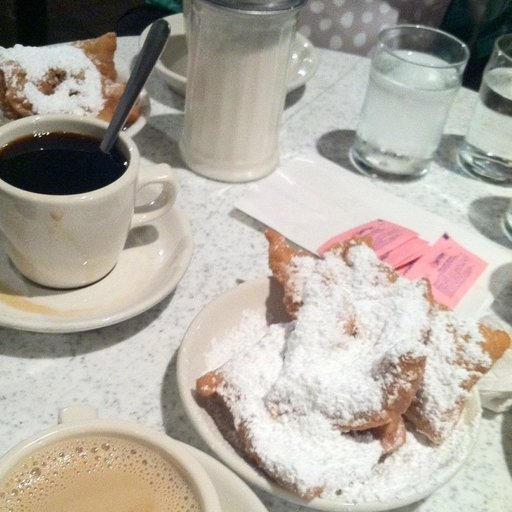

In [117]:
import datasets
import transformers
import torchvision.transforms
import evaluate
import numpy as np

ds = datasets.load_dataset("food101", split="validation[:10]")
image = ds["image"][0]
image
# classifier(image)
# image vs. classifier(image)

In [118]:
classifier(image)

[{'label': 'beignets', 'score': 0.9714367389678955},
 {'label': 'chicken_wings', 'score': 0.6107726693153381},
 {'label': 'prime_rib', 'score': 0.6023385524749756},
 {'label': 'hamburger', 'score': 0.5858390927314758},
 {'label': 'ramen', 'score': 0.5835704207420349}]

# ÏÇ¥Ìé¥Î≥¥Í∏∞

### Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [119]:
food_full = datasets.load_dataset("food101")
food_full
# ÏûêÎ£åÍ∞Ä ÏïΩ 10ÎßåÍ∞ú(75750+25250), ÏûêÎ£åÌòïÏùÄ DatasetDict ÏûÑ

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

In [120]:
food5000 = datasets.load_dataset("food101", split="train[:5000]")
food5000
# ÏûêÎ£åÎäî 5000Í∞ú, ÏûêÎ£åÌòïÏùÄ Dataset
#train Ï§ëÏóêÏÑú 5000Í∞úÎßå Ï∂îÏ∂úÌï®

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

In [188]:
food = food5000.train_test_split(test_size=0.2)
food

#ÏñòÎäî Ïôú Îòê DatasetDictÏïº?
#test_size=0.2Ïùò ÏùòÎØ∏: testÏö©ÏúºÎ°ú 20%Îßå Îî∞Î°ú ÎπºÎÜî! -> testÏùò num_rowsÏùò Í∞úÏàòÍ∞Ä 1000Í∞ú

[79, 20, 10, 79, 10]

## Îç∞Ïù¥ÌÑ∞ ÏÇ¥Ìé¥Î≥¥Í∏∞

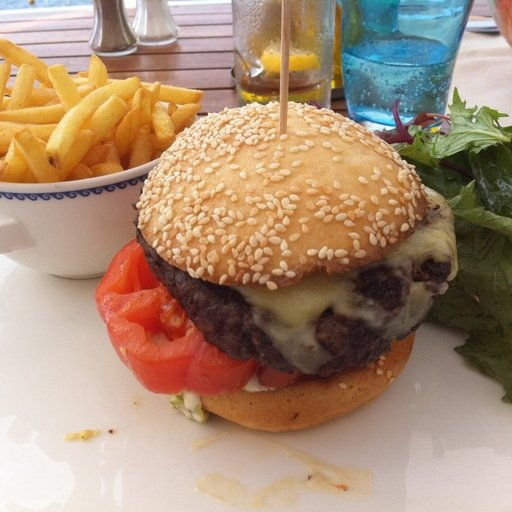

In [122]:
# Ïù¥ÎØ∏ÏßÄ Î≥¥Îäî Î∞©Î≤ï

food['train'][0]['image']

In [123]:
# Ïù¥ÎØ∏ÏßÄÏùò labelÏùÑ ÌôïÏù∏ÌïòÎäî Î∞©Î≤ï

food['train'][0]['label']

53

In [124]:
# ÎùºÎ≤® '53'Ïù¥ ÏùòÎØ∏ÌïòÎäî Î∞îÎäî?

labels = food['train'].features['label'].names
# Ïùò 53Î≤àÏß∏

In [125]:
labels = food['train'].features['label'].names
labels[53]

'hamburger'

In [126]:
food5000
#ÏñòÎäî 'train'Îûë, 'test'Í∞Ä ÎèÖÎ¶ΩÏ†ÅÏúºÎ°ú Ï°¥Ïû¨ÌïòÏßÄ ÏïäÎÑ§üëÄ

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

In [127]:
food

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

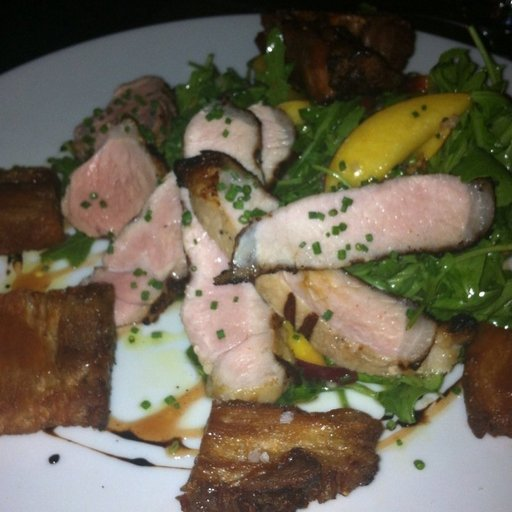

In [128]:
food['train'][25]['image']
# food['train'][255]['label']

In [129]:
labels = food['train'].features['label'].names
labels[25]

'club_sandwich'

In [130]:
# Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞ Ï°∞ÏÇ¨ÌïòÎäî Î∞©Î≤ï
# Î∞©Î≤ï 1

food['train'][0]

# size=512x512

{'image': <PIL.Image.Image image mode=RGB size=512x512>, 'label': 53}

In [131]:
food['train'][6]

# size=384x512

{'image': <PIL.Image.Image image mode=RGB size=384x512>, 'label': 81}

In [132]:
# Î∞©Î≤ï1
food['train'][3]['image'].__str__().split(' ')[-3].split("=")[-1].split("x")
sizes = [l['image'].__str__().split(' ')[-3].split("=")[-1].split("x") for l in food['train']]
sizes[:4]

[['512', '512'], ['512', '512'], ['512', '512'], ['512', '512']]

In [133]:
# Î∞©Î≤ï2
sizes = [l['image'].size for l in food['train']]
sizes[:4]

# imgÏùò ÎÇ¥Ïû• Ìï®Ïàò(size) Ïù¥Ïö©

[(512, 512), (512, 512), (512, 512), (512, 512)]

## torchvision.trasforms (**ÏûêÎ•¥Í≥†ÌÅ¨Í∏∞Ï°∞Ï†ïÌïòÍ∏∞**)

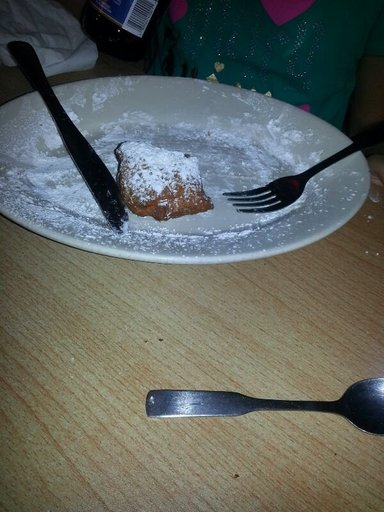

In [134]:
img = datasets.load_dataset("food101",split="train[:1]")[0]['image']
img

In [135]:
ÏûêÎ•¥Í≥†ÌÅ¨Í∏∞Ï°∞Ï†ïÌïòÍ∏∞ = torchvision.transforms.RandomResizedCrop((224,224))

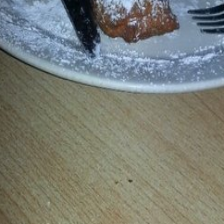

In [136]:
ÏûêÎ•¥Í≥†ÌÅ¨Í∏∞Ï°∞Ï†ïÌïòÍ∏∞(img)
# 'ÏûêÎ•¥Í≥†ÌÅ¨Í∏∞Ï°∞Ï†ïÌïòÍ∏∞' Ìï®ÏàòÏùò ÏûÖÎ†•Í∞íÏùÑ ÌÜµÌï¥ ÏÇ¨ÏßÑÏùò ÌÅ¨Í∏∞Î•º Ï°∞Ï†àÌï† Ïàò ÏûàÏùå, Ïà´Ïûê Ìïú Í∞úÎßå ÏûÖÎ†• Ïãú Ï†ïÏÇ¨Í∞ÅÌòï Î™®Ìòï.

```Python
ÏûêÎ•¥Í≥†ÌÅ¨Í∏∞Ï°∞Ï†ïÌïòÍ∏∞ = torchvision.transforms.RandomResizedCrop((224,112))
```
**RandomResizedCrop** Ïù¥Í∏∞ ÎïåÎ¨∏Ïóê, ÏÇ¨ÏßÑÏùÑ ÎûúÎç§ÏúºÎ°ú ÌÅ¨Î°≠ÌïòÍ≤å Îê®

## torchvision.transform.ToTensor() (**ÌÖêÏÑúÌôîÌïòÍ∏∞**)

In [137]:
ÌÖêÏÑúÌôîÌïòÍ∏∞ = torchvision.transforms.ToTensor()

In [138]:
dir(ÌÖêÏÑúÌôîÌïòÍ∏∞)
# callable Ìï®Ïàò -> ÏûÖÎ†•Í∞í Ë¶Å

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

In [139]:
ÌÖêÏÑúÌôîÌïòÍ∏∞(img).shape

# (3, 512, 384)
# 512ÏôÄ 384Îäî Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞
# 3ÏùÄ RGBÏùò Ï±ÑÎÑê

torch.Size([3, 512, 384])

In [140]:
# ÌÖêÏÑúÌôîÌïòÍ∏∞(ÏûêÎ•¥Í≥†ÌÅ¨Í∏∞Ï°∞Ï†ïÌïòÍ∏∞) ÏôÄ, ÏûêÎ•¥Í≥†ÌÅ¨Í∏∞Ï°∞Ï†ïÌïòÍ∏∞(ÌÖêÏÑúÌôîÌïòÍ∏∞) Ïùò Í≤∞Í≥ºÎäî ÎèôÏùºÌï®

## torchvision.transform.Nomalize (**ÌëúÏ§ÄÌôîÌïòÍ∏∞**)

In [141]:
ÌëúÏ§ÄÌôîÌïòÍ∏∞ = torchvision.transforms.Normalize(mean=[10,20,30],std=[0.5,1.0,1.5])

In [142]:
ÌëúÏ§ÄÌôîÌïòÍ∏∞(ÌÖêÏÑúÌôîÌïòÍ∏∞(img))
# Ïà´ÏûêÎì§Ïù¥ Í≥ÑÏÇ∞Îê®

tensor([[[-19.7569, -19.7725, -19.7804,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7490, -19.7569, -19.7647,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7412, -19.7490, -19.7490,  ..., -19.9922, -20.0000, -20.0000],
         ...,
         [-19.4824, -19.4510, -19.4275,  ..., -19.2471, -19.2392, -19.2157],
         [-19.5294, -19.5059, -19.4667,  ..., -19.3255, -19.3255, -19.3255],
         [-19.5529, -19.5451, -19.5059,  ..., -19.3333, -19.3647, -19.3882]],

        [[-19.8627, -19.8706, -19.8745,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8588, -19.8627, -19.8667,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8549, -19.8588, -19.8588,  ..., -19.8980, -19.9020, -19.9020],
         ...,
         [-19.7529, -19.7373, -19.7255,  ..., -19.6353, -19.6235, -19.6118],
         [-19.7765, -19.7647, -19.7451,  ..., -19.6745, -19.6667, -19.6667],
         [-19.7882, -19.7843, -19.7647,  ..., -19.6784, -19.6863, -19.6980]],

        [[-19.9059, -19.9111, -19.9085,  ...

In [143]:
(ÌÖêÏÑúÌôîÌïòÍ∏∞(img)[0]-10)/0.5

tensor([[-19.7569, -19.7725, -19.7804,  ..., -19.9922, -19.9922, -20.0000],
        [-19.7490, -19.7569, -19.7647,  ..., -19.9922, -19.9922, -20.0000],
        [-19.7412, -19.7490, -19.7490,  ..., -19.9922, -20.0000, -20.0000],
        ...,
        [-19.4824, -19.4510, -19.4275,  ..., -19.2471, -19.2392, -19.2157],
        [-19.5294, -19.5059, -19.4667,  ..., -19.3255, -19.3255, -19.3255],
        [-19.5529, -19.5451, -19.5059,  ..., -19.3333, -19.3647, -19.3882]])

In [144]:
ÌëúÏ§ÄÌôîÌïòÍ∏∞(ÌÖêÏÑúÌôîÌïòÍ∏∞(img))

tensor([[[-19.7569, -19.7725, -19.7804,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7490, -19.7569, -19.7647,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7412, -19.7490, -19.7490,  ..., -19.9922, -20.0000, -20.0000],
         ...,
         [-19.4824, -19.4510, -19.4275,  ..., -19.2471, -19.2392, -19.2157],
         [-19.5294, -19.5059, -19.4667,  ..., -19.3255, -19.3255, -19.3255],
         [-19.5529, -19.5451, -19.5059,  ..., -19.3333, -19.3647, -19.3882]],

        [[-19.8627, -19.8706, -19.8745,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8588, -19.8627, -19.8667,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8549, -19.8588, -19.8588,  ..., -19.8980, -19.9020, -19.9020],
         ...,
         [-19.7529, -19.7373, -19.7255,  ..., -19.6353, -19.6235, -19.6118],
         [-19.7765, -19.7647, -19.7451,  ..., -19.6745, -19.6667, -19.6667],
         [-19.7882, -19.7843, -19.7647,  ..., -19.6784, -19.6863, -19.6980]],

        [[-19.9059, -19.9111, -19.9085,  ...

In [145]:
# ÎòëÍ∞ôÎã§!

```Python
(ÌÖêÏÑúÌôîÌïòÍ∏∞(img)[0]-10)/0.5
```
[0]-10... Î∂ÄÎ∂ÑÏù¥
```Python
ÌëúÏ§ÄÌôîÌïòÍ∏∞ = torchvision.transforms.Normalize(mean=[10,20,30],std=[0.5,1.0,1.5])
```
(mean=[10...)Ïóê ÎåÄÏùë

In [146]:
ÌÖêÏÑúÌôîÌïòÍ∏∞(img)[0] # R
ÌÖêÏÑúÌôîÌïòÍ∏∞(img)[1] # G
ÌÖêÏÑúÌôîÌïòÍ∏∞(img)[2] # B

tensor([[0.1412, 0.1333, 0.1373,  ..., 0.0902, 0.0902, 0.0863],
        [0.1451, 0.1412, 0.1451,  ..., 0.0902, 0.0902, 0.0863],
        [0.1569, 0.1529, 0.1529,  ..., 0.0902, 0.0863, 0.0863],
        ...,
        [0.1725, 0.1882, 0.2000,  ..., 0.2431, 0.2549, 0.2667],
        [0.1490, 0.1608, 0.1804,  ..., 0.2039, 0.2118, 0.2118],
        [0.1373, 0.1412, 0.1608,  ..., 0.2000, 0.1922, 0.1804]])

`ÌëúÏ§ÄÌôîÌïòÍ∏∞`Îäî Í∞Å Ï±ÑÎÑêÎ≥ÑÎ°ú, `mean`ÏùÑ Î∫Ä Îí§, `std`Î•º ÎÇòÎàà Í≥ÑÏÇ∞Í∞íÏùÑ returnÌï®

## torchvision.transforms.Compose (**Ïó¨Îü¨ Ìï®Ïàò Î¨∂Í∏∞**)

<Ïù¥ÎØ∏ÏßÄ Í∞ÄÍ≥µ ÏàúÏÑú>

ÏûêÎ•¥Í≥†ÌÅ¨Í∏∞Ï°∞Ï†ïÌïòÍ∏∞$\to$ÌÖêÏÑúÌôîÌïòÍ∏∞$\to$ÌëúÏ§ÄÌôîÌïòÍ∏∞

In [147]:
ÌëúÏ§ÄÌôîÌïòÍ∏∞(ÌÖêÏÑúÌôîÌïòÍ∏∞(ÏûêÎ•¥Í≥†ÌÅ¨Í∏∞Ï°∞Ï†ïÌïòÍ∏∞(img)))

# Ïù¥Îü∞ Î∞©ÏãùÏù¥ ÎπÑÌö®Ïú®Ï†ÅÏûÑ

tensor([[[-19.2627, -19.2863, -19.2549,  ..., -19.6706, -19.8510, -19.9373],
         [-19.2471, -19.2627, -19.2784,  ..., -19.3804, -19.5294, -19.6863],
         [-19.2627, -19.2941, -19.2549,  ..., -19.2863, -19.3412, -19.3961],
         ...,
         [-19.2078, -19.2392, -19.2627,  ..., -19.0431, -19.0510, -19.0118],
         [-19.2314, -19.2627, -19.2627,  ..., -18.9882, -19.0353, -19.0431],
         [-19.2784, -19.2549, -19.2549,  ..., -19.0745, -19.0510, -19.0275]],

        [[-19.5922, -19.6039, -19.5882,  ..., -19.7412, -19.8196, -19.8627],
         [-19.5804, -19.5882, -19.5922,  ..., -19.6118, -19.6784, -19.7529],
         [-19.5882, -19.5961, -19.5765,  ..., -19.5765, -19.5961, -19.6196],
         ...,
         [-19.6157, -19.6314, -19.6431,  ..., -19.5490, -19.5490, -19.5294],
         [-19.6275, -19.6392, -19.6392,  ..., -19.5176, -19.5373, -19.5412],
         [-19.6549, -19.6353, -19.6392,  ..., -19.5647, -19.5490, -19.5373]],

        [[-19.7098, -19.7124, -19.7020,  ...

In [148]:
Ïù¥ÎØ∏ÏßÄÏ≤òÎ¶¨ÌïòÍ∏∞ = torchvision.transforms.Compose([ÏûêÎ•¥Í≥†ÌÅ¨Í∏∞Ï°∞Ï†ïÌïòÍ∏∞, ÌÖêÏÑúÌôîÌïòÍ∏∞, ÌëúÏ§ÄÌôîÌïòÍ∏∞])

In [149]:
dir(Ïù¥ÎØ∏ÏßÄÏ≤òÎ¶¨ÌïòÍ∏∞)

# Ïù¥ÎØ∏ÏßÄÏ≤òÎ¶¨ÌïòÍ∏∞ Ìï®ÏàòÎäî callable function

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'transforms']

In [150]:
Ïù¥ÎØ∏ÏßÄÏ≤òÎ¶¨ÌïòÍ∏∞(img)

tensor([[[-19.4118, -19.4588, -19.4902,  ..., -19.9922, -19.9922, -20.0000],
         [-19.4039, -19.4353, -19.4667,  ..., -19.9922, -19.9922, -20.0000],
         [-19.4039, -19.4431, -19.4431,  ..., -20.0000, -20.0000, -20.0000],
         ...,
         [-19.1373, -19.1529, -19.1922,  ..., -18.9961, -18.9333, -18.8706],
         [-19.2000, -19.1373, -19.1216,  ..., -19.0196, -19.0510, -19.0275],
         [-19.1294, -19.1843, -19.0980,  ..., -18.9412, -19.0118, -19.0431]],

        [[-19.6706, -19.6863, -19.6941,  ..., -19.8431, -19.8431, -19.8471],
         [-19.6667, -19.6784, -19.6902,  ..., -19.8431, -19.8431, -19.8471],
         [-19.6706, -19.6863, -19.6824,  ..., -19.8471, -19.8471, -19.8471],
         ...,
         [-19.5961, -19.6039, -19.6157,  ..., -19.5373, -19.5098, -19.4784],
         [-19.6353, -19.6000, -19.5843,  ..., -19.5490, -19.5686, -19.5569],
         [-19.6078, -19.6275, -19.5804,  ..., -19.5137, -19.5490, -19.5647]],

        [[-19.7542, -19.7647, -19.7725,  ...

# Ïù¥ÎØ∏ÏßÄÏ†ÑÏ≤òÎ¶¨

In [151]:
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size),
    torchvision.transforms.ToTensor(),
    normalize
])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food = food.with_transform(transforms)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


```Python
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
  ```


ÏóêÏÑú

`mean`ÏùÄ Í∞ÅÍ∞Å `[0.5, 0.5, 0.5]`Í∞Ä ÎêòÎ©∞, `std`ÏùÄ Í∞ÅÍ∞Å `[0.5, 0.5, 0.5]`Í∞Ä Îê®.

(‚Äª `image_processor` Î•º Ï∂úÎ†•Ìï¥Î≥¥Î©¥ Ïïå Ïàò ÏûàÏùå.)

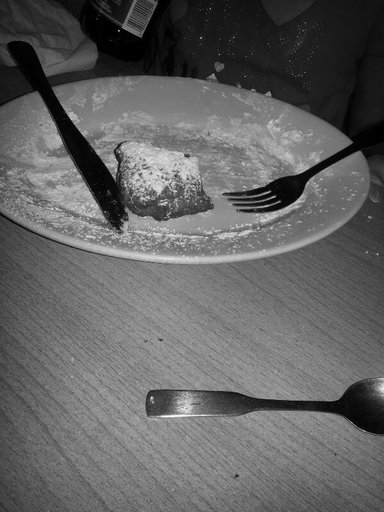

In [152]:
img.convert("L")

# ÌùëÎ∞±

## image_precessor




In [153]:
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

## size

In [154]:
size = image_processor.size["shortest_edge"] if "shortest_edge" in image_processor.size else (image_processor.size["height"], image_processor.size["width"])

In [155]:
size

# (224, 224) Í∞Ä ÏùòÎØ∏ÌïòÎäî Í≤ÉÏùÄ Î¨¥ÏóáÏùºÍπå?

(224, 224)

```python
size = image_processor.size["shortest_edge"] if "shortest_edge" in image_processor.size else (image_processor.size["height"], image_processor.size["width"])
```

1. ÎßåÏïΩ `image_processor.size`Ïóê `shortest_edge(Ï†úÏùº ÏûëÏùÄ ÏÇ¨ÏßÑ ÌÅ¨Í∏∞)`Í∞Ä **ÏûàÎã§Î©¥** $\to$ Í∑∏ Í∞íÏùÑ `size`Î°ú ÏßÄÏ†ïÌï®
2.  ÎßåÏïΩ `image_processor.size`Ïóê `shortest_edge(Ï†úÏùº ÏûëÏùÄ ÏÇ¨ÏßÑ ÌÅ¨Í∏∞)`Í∞Ä **ÏóÜÎã§Î©¥** $\to$ `[height]`ÏôÄ `[width]` Í∞íÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ `([height], [width])`Ïùò ÌäúÌîåÎ°ú Ï†ÄÏû•Ìï®

## transforms(example)

```Python
food = datasets.load_dataset("food101", split="train[:5000]")
food = food.train_test_split(test_size=0.2)
```
ÎùºÎäî Í≤ÉÏùÑ Îã§Ïãú ÏïåÎ†§Ï£ºÍ≥†, Ïù¥ÌõÑ `food_transformed`ÎùºÎäî Ìï®ÏàòÎ•º Î∂àÎü¨ÏôÄÏïº Ìï®.

ÎßåÏïΩÏóê `food_transformed`ÎùºÎäî Ìï®ÏàòÎ•º Î®ºÏ†Ä Ï†ïÏùòÌïòÍ≥†, `food`Îç∞Ïù¥ÌÑ∞ Í∞íÏùÑ Ïû¨Ï†ïÏùòÌïúÎã§Î©¥, ÎÇ¥Í∞Ä ÏïûÏÑú Ïù¥ÎØ∏ Î∂ÄÎ•∏ `food`Ïóê ÎåÄÌï¥ÏÑú `tranformed`Ìï®ÏàòÎ•º Î®ºÏ†Ä Ïã§Ìñâ $\to$ ÏÉàÎ°úÏö¥ `food` Í∞íÏúºÎ°ú `food['train'][ÏÇ¨Ïö©ÏûêÍ∞ÄÏõêÌïòÎäîÍµ¨Í∞Ñ]['label']`ÏùÑ Ïã§ÌñâÌï† Í≤ÉÏûÑ.

In [215]:
food = datasets.load_dataset("food101", split="train[:5000]")
food = food.train_test_split(test_size=0.2)
food['train'][0:5]['label']

[6, 10, 81, 20, 6]

In [216]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food_transformed = food.with_transform(transforms)

```python
def "transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food_transformed = food.with_transform(transforms)
```

1. ("L")Ïùº ÏàòÎèÑ ÏûàÏúºÎãà, convert("RGB") ÌïòÏó¨Îùº. Ïù¥Îïå ÏÇ¨Ïö©ÎêòÎäî Ìï®ÏàòÎäî _transforms
2. Î≥ÄÌôòÎêòÍ∏∞ Ïù¥Ï†ÑÏùò ÏõêÎ≥∏ÏùÄ `del`ÌïòÏó¨ Î©îÎ™®Î¶¨ Ìôï

In [217]:
food_transformed['train'][0:5]['label']

[6, 10, 81, 20, 6]

In [218]:
food_transformed['train'][0:5]['label']

[6, 10, 81, 20, 6]

In [219]:
food['train'][0:5]['label']

[6, 10, 81, 20, 6]

In [197]:
examples = food['train'][0:5]
transforms(examples)

{'label': [10, 81, 6, 79, 20],
 'pixel_values': [tensor([[[-0.0745,  0.0824,  0.1451,  ...,  0.0667,  0.0667,  0.1137],
           [ 0.0745,  0.1451,  0.1765,  ...,  0.0431,  0.0980,  0.1059],
           [ 0.1294,  0.1843,  0.2000,  ...,  0.0353,  0.0667,  0.0353],
           ...,
           [ 0.4510,  0.4667,  0.4824,  ..., -0.0902, -0.0275,  0.0902],
           [ 0.4588,  0.4745,  0.4824,  ...,  0.2784,  0.0275, -0.0510],
           [ 0.4745,  0.4588,  0.4667,  ...,  0.6157,  0.5216,  0.3020]],
  
          [[-0.1843, -0.0118,  0.0667,  ..., -0.0980, -0.0980, -0.0510],
           [-0.0275,  0.0588,  0.1059,  ..., -0.1137, -0.0588, -0.0510],
           [ 0.0510,  0.1059,  0.1294,  ..., -0.1137, -0.0745, -0.1059],
           ...,
           [ 0.4039,  0.4118,  0.4196,  ..., -0.2314, -0.1765, -0.0824],
           [ 0.4118,  0.4039,  0.4118,  ...,  0.1608, -0.1059, -0.2157],
           [ 0.4039,  0.3882,  0.3882,  ...,  0.5137,  0.3961,  0.1529]],
  
          [[-0.2706, -0.0745,  0.0353

In [205]:
food_transformed['train'][0:5]['label']

[79, 20, 10, 79, 10]

In [207]:
ssibal = food['train'][0:5]['label']
# transforms(ssibal)
ssibal

[10, 81, 6, 79, 20]

```python
food_transformed = food.with_transform(transforms)
```
`-` ÏßÄÏó∞ ÏΩîÎìú

In [250]:
examples = food['train'][0:5]

In [251]:
examples
# 1st, ÏûêÏÑ∏ÌïòÍ≤å

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
  <PIL.Image.Image image mode=RGB size=512x289>,
  <PIL.Image.Image image mode=RGB size=512x512>,
  <PIL.Image.Image image mode=RGB size=382x512>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>],
 'label': [6, 10, 81, 20, 6]}

In [252]:
transforms(examples)
# 2nd
# food_transformed['train'][0:5] ÏôÄ ÎèôÏùºÌïú Í≤∞Í¥èÍ∞í

{'label': [6, 10, 81, 20, 6],
 'pixel_values': [tensor([[[-0.0902, -0.4902, -0.6157,  ...,  0.5765,  0.5765,  0.5765],
           [-0.0588, -0.4196, -0.5608,  ...,  0.6078,  0.6078,  0.6157],
           [-0.0745, -0.3725, -0.5137,  ...,  0.6392,  0.6392,  0.6549],
           ...,
           [ 0.1451,  0.1608,  0.1843,  ..., -0.0745, -0.0824, -0.0980],
           [ 0.1529,  0.1608,  0.1765,  ..., -0.1451, -0.1608, -0.1686],
           [ 0.1529,  0.1608,  0.1686,  ..., -0.2078, -0.2392, -0.2392]],
  
          [[-0.2314, -0.6471, -0.8118,  ...,  0.4353,  0.4431,  0.4510],
           [-0.2235, -0.6000, -0.7725,  ...,  0.4667,  0.4824,  0.4902],
           [-0.2627, -0.5922, -0.7333,  ...,  0.5059,  0.5137,  0.5294],
           ...,
           [-0.0667, -0.0431, -0.0275,  ..., -0.2627, -0.2627, -0.2784],
           [-0.0667, -0.0588, -0.0510,  ..., -0.3490, -0.3647, -0.3647],
           [-0.0824, -0.0667, -0.0745,  ..., -0.4196, -0.4588, -0.4588]],
  
          [[-0.3647, -0.7412, -0.8667,

# Î™®Îç∏ÏÉùÏÑ±

## Ïù∏Í≥µÏßÄÎä•ÏùÑ ÎßåÎì§Í∏∞ ÏúÑÌïú Ï§ÄÎπÑÏΩîÎìú

In [224]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [225]:
food['train'].features['label']

ClassLabel(names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'mac

In [226]:
# label2id, id2label
# ÎùºÎ≤®Í≥º Î©îÎâ¥ Èñì Îß§Ìïë

In [227]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [228]:
# labels

In [229]:
Î™®Îç∏ÏÉùÏÑ±ÌïòÍ∏∞ = model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [230]:
model(Ïù¥ÎØ∏ÏßÄÏ≤òÎ¶¨ÌïòÍ∏∞(img))

# Ïã§ÌñâÏù¥ Ïïà Îèº!
# Ïù∏Í≥µÏßÄÎä•ÏùÄ **Ïó¨Îü¨ Ïû•**Ïùò Ïù¥ÎØ∏ÏßÄ(Î∞∞ÏπòÌòïÌÉú)Î•º ÏûÖÎ†•Í∞íÏúºÎ°ú Î∞õÏùÑ Í≤ÉÏùÑ ÏòàÏÉÅÌïòÍ∏∞ ÎïåÎ¨∏.
# ÎßåÏïΩ Ìïú Ïû•Ïù¥ÎùºÎ©¥ reshapeÎ•º Ìï¥Ï§òÏïº Ìï®

ValueError: not enough values to unpack (expected 4, got 3)

In [231]:
Ïù¥ÎØ∏ÏßÄÏ≤òÎ¶¨ÌïòÍ∏∞(img).shape

# Ïù¥ÎØ∏ÏßÄÏ≤òÎ¶¨ÌïòÍ∏∞ = torchvision.transforms.Compose([ÏûêÎ•¥Í≥†ÌÅ¨Í∏∞Ï°∞Ï†ïÌïòÍ∏∞, ÌÖêÏÑúÌôîÌïòÍ∏∞, ÌëúÏ§ÄÌôîÌïòÍ∏∞])
# food = food.with_transform(transforms)
# "Ïù¥ÎØ∏ÏßÄÏ≤òÎ¶¨ÌïòÍ∏∞" Ìï®ÏàòÎäî ÏûêÎ•¥Í≥†, ÌÖêÏÑúÌôîÌïòÍ≥†, ÌëúÏ§ÄÌôîÌïòÍ≥†, ÌùëÎ∞±Ïù¥Î©¥ Ïª¨Îü¨Î°ú Î∞îÍæ∏Í≥†, Î∞îÍæ∏Í∏∞ Ïù¥Ï†Ñ ÏÇ¨ÏßÑÏùÄ delÌïòÍ≥†!
# ÍπåÏßÄÏùò Í≥ºÏ†ïÏùÑ Í±∞Ïπ®

torch.Size([3, 224, 224])

In [232]:
Ïù¥ÎØ∏ÏßÄÏ≤òÎ¶¨ÌïòÍ∏∞(img).reshape(1,3,224,224)

tensor([[[[-19.9765, -19.9294, -19.8196,  ..., -19.9059, -19.8980, -19.8902],
          [-19.9922, -19.9765, -19.7490,  ..., -19.9059, -19.8980, -19.8980],
          [-19.9843, -19.9922, -19.8902,  ..., -19.8980, -19.8980, -19.8980],
          ...,
          [-19.1843, -19.1765, -19.2235,  ..., -19.2157, -19.1137, -19.1137],
          [-19.2627, -19.1608, -19.1137,  ..., -19.2314, -19.2157, -19.2000],
          [-19.2157, -19.2235, -19.1373,  ..., -19.1373, -19.1686, -19.2235]],

         [[-19.9725, -19.9451, -19.8863,  ..., -19.9451, -19.9451, -19.9373],
          [-19.9804, -19.9647, -19.8431,  ..., -19.9490, -19.9451, -19.9373],
          [-19.9725, -19.9765, -19.9176,  ..., -19.9451, -19.9412, -19.9333],
          ...,
          [-19.5961, -19.5882, -19.6118,  ..., -19.6353, -19.5843, -19.5843],
          [-19.6314, -19.5765, -19.5569,  ..., -19.6431, -19.6353, -19.6275],
          [-19.6118, -19.6078, -19.5725,  ..., -19.5961, -19.6118, -19.6392]],

         [[-19.9817, -19.9634,

```python
Ïù¥ÎØ∏ÏßÄÏ≤òÎ¶¨ÌïòÍ∏∞(img).reshape(1,3,224,224)
```

Ïù¥Îü∞ ÏãùÏúºÎ°ú ÏàòÏ†ïÌï¥Ï§òÏïº ÌïúÎã§.

Ïó¨Í∏∞ÏÑú,`.reshape`Ïùò Í¥ÑÌò∏ Ïïà Ïà´ÏûêÎì§Ïùò ÏùòÎØ∏Îäî

.reshape(1=Ïù¥ÎØ∏ÏßÄÍ∞úÏàò, 3=Ï∞®ÏõêÏùòÍ∞úÏàò, 224&224=Ïù¥ÎØ∏ÏßÄÏùòÌÅ¨Í∏∞)


`.reshape`Ïùò Í≥ºÏ†ïÏùÑ **Îç∞Ïù¥ÌÑ∞ÏΩúÎ†âÌÑ∞**Í∞Ä ÏàòÌñâÌï®

# Îç∞Ïù¥ÌÑ∞ÏΩúÎ†âÌÑ∞

`-` Îç∞Ïù¥ÌÑ∞ÏΩúÎ†âÌÑ∞ ÏÉùÏÑ±
- ÌÖçÏä§Ìä∏ÌòïÏóêÏÑú ÏÇ¨Ïö©Ìï† ÎïåÎäî ÏûêÎ£åÌòïÏùÑ ÌååÏù¥ÌÜ†Ïπò ÌÖêÏÑúÌòïÏúºÎ°ú Î∞îÍøîÏ£ºÍ∏∞ÎèÑ ÌïòÍ≥†, ÎèôÏ†Å Ìå®Îî©ÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Ï†ÅÏ†àÌïú Í∏∏Ïù¥Î°ú ÏûòÎùºÏ£ºÍ∏∞/Ï±ÑÏõåÏ£ºÍ∏∞ÎèÑ ÌïòÍ≥†, Ïó¨Îü¨ Í∞úÏî© Î¨∂Ïñ¥ Î∞∞ÏπòÌòïÌÉúÎ°ú ÎßåÎì§Ïñ¥ Ï£ºÍ∏∞ÎèÑ ÌïòÏòÄÏùå
- ÌïòÏßÄÎßå Ïù¥ÎØ∏ resize, ÌÖêÏÑúÌôîÎ•º ÎÅùÎÉàÏúºÎØÄÎ°ú Ïù¥ÎØ∏ÏßÄÌòïÏóêÏÑúÎäî Îç∞Ïù¥ÌÑ∞ÏΩúÎ†âÌÑ∞Ïùò ÎπÑÏ§ëÏù¥ ÌÅ¨ÏßÄ ÏïäÏùå$\to$ ÎØ∏ÎãàÎ∞∞ÏπòÏùò Í∏∞Îä•Îßå ÏàòÌñâÌïòÎäî Ï†ïÎèÑ
- `Dict,Dict,Dict...`Ïùò Íº¥Ïù¥ÏóàÏùå


In [233]:
 data_collator = transformers.DefaultDataCollator()

In [234]:
# food_transformed['train'][:2]['pixel_values'].shape    <<<<<< Ïò§Î•ò

# ÏßÄÍ∏à Ïù¥ÎØ∏ÏßÄÎÅºÎ¶¨ tensorÍ∞Ä Îî∞Î°ú(?) Ï°¥Ïû¨Ìï®
# .reshapeÏùò Í≥ºÏ†ïÏùÑ ÏïÑÏßÅ Í±∞ÏπòÏßÄ Î™ª ÌïòÏó¨ modelÏóê ÎÑ£ÏßÄ Î™ª Ìï®

In [235]:
import torch
torch.stack(food_transformed['train'][:2]['pixel_values'],axis=0).shape

# ÏàòÎèôÏúºÎ°ú ÌïúÎ≤à Ìï¥Î≥¥Ïûê!
# Í≤∞Í≥º) resizeÍ∞Ä Ïã§ÌñâÎê®

torch.Size([2, 3, 224, 224])

In [236]:
data_collator([food_transformed['train'][0],food_transformed['train'][1]])['pixel_values'].shape

# Í≤∞Í≥º) resizeÍ∞Ä Ïã§ÌñâÎê®

torch.Size([2, 3, 224, 224])

# Ï∂îÎ°†

In [237]:
# Step4
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-186")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [238]:
ds = datasets.load_dataset("food101", split="validation[:10]")
image = ds["image"][0]
classifier(image)

[{'label': 'beignets', 'score': 0.9714367389678955},
 {'label': 'chicken_wings', 'score': 0.6107726693153381},
 {'label': 'prime_rib', 'score': 0.6023385524749756},
 {'label': 'hamburger', 'score': 0.5858390927314758},
 {'label': 'ramen', 'score': 0.5835704207420349}]

In [239]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

Q. ÌÉÄÏûÖÏù¥ `JpegImageFile`Ïù∏ Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏùÑ Ï†ÑÎã¨ÌïòÎ©¥ `classifier`Í∞Ä ÏïåÏïÑÏÑú Íµ¨Î≥ÑÌï¥Ï£ºÏßÄ ÏïäÏùÑÍπå...?

In [240]:
# from PIL import Image
# import requests
# from io import BytesIO

# # Ïù¥ÎØ∏ÏßÄ URL
# url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Shoyu_ramen%2C_at_Kasukabe_Station_%282014.05.05%29_1.jpg/500px-Shoyu_ramen%2C_at_Kasukabe_Station_%282014.05.05%29_1.jpg"

# # URLÏóêÏÑú Ïù¥ÎØ∏ÏßÄ Î∂àÎü¨Ïò§Í∏∞
# response = requests.get(url)
# image = Image.open(BytesIO(response.content))
# image

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7a8829121710>

In [241]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [242]:
classifier(image)

[{'label': 'beignets', 'score': 0.9714367389678955},
 {'label': 'chicken_wings', 'score': 0.6107726693153381},
 {'label': 'prime_rib', 'score': 0.6023385524749756},
 {'label': 'hamburger', 'score': 0.5858390927314758},
 {'label': 'ramen', 'score': 0.5835704207420349}]

# ÏΩîÎìúÏ†ïÎ¶¨ 2

In [ ]:
# ## Step1
# food = datasets.load_dataset("food101", split="train[:5000]").train_test_split(test_size=0.2)
# image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
# def transforms(examples):
#     _transforms = torchvision.transforms.Compose([
#         torchvision.transforms.RandomResizedCrop(224),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
#     ])
#     examples["pixel_values"] = [_transforms(img) for img in examples["image"]]
#     del examples["image"]
#     return examples
# food = food.with_transform(transforms)
# ## Step2
# labels = food["train"].features["label"].names
# label2id, id2label = dict(), dict()
# for i, label in enumerate(labels):
#     label2id[label] = i
#     id2label[i] = label
# model = transformers.AutoModelForImageClassification.from_pretrained(
#     "google/vit-base-patch16-224-in21k",
#     num_labels=len(labels),
#     id2label=id2label,
#     label2id=label2id,
# )
# ## Step3
# data_collator = transformers.DefaultDataCollator()
# accuracy = evaluate.load("accuracy")
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return accuracy.compute(predictions=predictions, references=labels)
# training_args = transformers.TrainingArguments(
#     output_dir="my_awesome_food_model",
#     remove_unused_columns=False,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=5e-5,
#     per_device_train_batch_size=16,
#     gradient_accumulation_steps=4,
#     per_device_eval_batch_size=16,
#     num_train_epochs=4,
#     warmup_ratio=0.1,
#     logging_steps=10,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     push_to_hub=False,
#     report_to="none"
# )
# trainer = transformers.Trainer(
#     model=model,
#     args=training_args,
#     data_collator=data_collator,
#     train_dataset=food["train"],
#     eval_dataset=food["test"],
#     tokenizer=image_processor,
#     compute_metrics=compute_metrics,
# )
# trainer.train()
# ## Step4